# 07 - Machine Learning Models (LightGBM)

This notebook trains and evaluates ML models for traffic prediction:

1. **LightGBM** - Gradient boosting with feature engineering
2. **Optuna Tuning** - Bayesian hyperparameter optimization
3. **SHAP Analysis** - Model interpretability
4. **Final Comparison** - All models comparison

In [1]:
# Standard imports
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# ML imports
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

# Project imports
from src.models.lgbm_model import LGBMModel, LGBMConfig
from src.utils.metrics import evaluate_forecast, compare_models, print_metrics

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print(f"Project root: {project_root}")

Project root: c:\Users\Admin\OneDrive\Documents\python\datafollow


## 1. Load Data

In [2]:
# Paths
DATA_DIR = project_root / "DATA"
PROCESSED_DIR = DATA_DIR / "processed"
MODELS_DIR = project_root / "models"
MODELS_DIR.mkdir(exist_ok=True)

# Load feature-engineered data
df_train = pd.read_parquet(PROCESSED_DIR / "train_features_5m.parquet")
df_test = pd.read_parquet(PROCESSED_DIR / "test_features_5m.parquet")

# Load feature info
with open(PROCESSED_DIR / "feature_info.json", 'r') as f:
    feature_info = json.load(f)

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

Train shape: (15264, 91)
Test shape: (2592, 91)


In [3]:
# Define target and features
TARGET = 'request_count'

# Exclude non-feature columns
# IMPORTANT: Also exclude 'request_count_pct_of_max' - DATA LEAKAGE (r=1.0 with target!)
exclude_cols = [
    'timestamp', 
    'time_of_day', 
    'part_of_day', 
    TARGET,
    'request_count_pct_of_max',  # DATA LEAKAGE - derived from target, correlation = 1.0!
]

# Get numeric features
feature_cols = [c for c in df_train.select_dtypes(include=[np.number]).columns 
                if c not in exclude_cols]

print(f"Target: {TARGET}")
print(f"Features: {len(feature_cols)}")
print(f"\n⚠️ Removed 'request_count_pct_of_max' to prevent data leakage")
print(f"\nFirst 20 features: {feature_cols[:20]}")

Target: request_count
Features: 86

⚠️ Removed 'request_count_pct_of_max' to prevent data leakage

First 20 features: ['unique_hosts', 'error_count', 'error_rate', 'success_rate', 'bytes_total', 'bytes_avg', 'bytes_max', 'requests_per_host', 'bytes_per_request', 'year', 'month', 'day', 'hour', 'minute', 'day_of_week', 'day_of_year', 'week_of_year', 'is_weekend', 'is_business_hour', 'is_peak_hour']


In [4]:
# Prepare train/val/test splits
# Use last 20% of training for validation
val_size = int(len(df_train) * 0.2)

X_train_full = df_train[feature_cols]
y_train_full = df_train[TARGET]

X_train = X_train_full.iloc[:-val_size]
y_train = y_train_full.iloc[:-val_size]

X_val = X_train_full.iloc[-val_size:]
y_val = y_train_full.iloc[-val_size:]

X_test = df_test[feature_cols]
y_test = df_test[TARGET]

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (12212, 86)
X_val shape: (3052, 86)
X_test shape: (2592, 86)


In [5]:
# Handle any NaN values
X_train = X_train.fillna(X_train.median())
X_val = X_val.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())

print(f"NaN in X_train: {X_train.isna().sum().sum()}")
print(f"NaN in X_val: {X_val.isna().sum().sum()}")
print(f"NaN in X_test: {X_test.isna().sum().sum()}")

NaN in X_train: 0
NaN in X_val: 0
NaN in X_test: 0


## 1.5 Data Scaling (RobustScaler)

RobustScaler uses median and IQR - more robust to outliers than StandardScaler.
NASA traffic data has spikes, so RobustScaler is preferred.

In [7]:
# Check for inf/nan values before scaling
print("Checking for inf/nan values...")
print(f"X_train - inf: {np.isinf(X_train).sum().sum()}, nan: {np.isnan(X_train).sum().sum()}")
print(f"X_val - inf: {np.isinf(X_val).sum().sum()}, nan: {np.isnan(X_val).sum().sum()}")
print(f"X_test - inf: {np.isinf(X_test).sum().sum()}, nan: {np.isnan(X_test).sum().sum()}")

# Replace inf with large finite values
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_val.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill any remaining NaN with median
X_train.fillna(X_train.median(), inplace=True)
X_val.fillna(X_train.median(), inplace=True)
X_test.fillna(X_train.median(), inplace=True)

print(f"\nAfter cleaning:")
print(f"X_train - inf: {np.isinf(X_train).sum().sum()}, nan: {np.isnan(X_train).sum().sum()}")
print(f"X_val - inf: {np.isinf(X_val).sum().sum()}, nan: {np.isnan(X_val).sum().sum()}")
print(f"X_test - inf: {np.isinf(X_test).sum().sum()}, nan: {np.isnan(X_test).sum().sum()}")

Checking for inf/nan values...
X_train - inf: 1552, nan: 0
X_val - inf: 54, nan: 0
X_test - inf: 12, nan: 0

After cleaning:
X_train - inf: 0, nan: 0
X_val - inf: 0, nan: 0
X_test - inf: 0, nan: 0


In [8]:
# ============================================================
# DATA SCALING - RobustScaler
# ============================================================
from sklearn.preprocessing import RobustScaler
import joblib

print("=" * 60)
print("DATA SCALING WITH ROBUSTSCALER")
print("=" * 60)

print("\n📊 Why RobustScaler?")
print("- StandardScaler: Uses mean & std → sensitive to outliers")
print("- RobustScaler: Uses median & IQR → robust to outliers")
print("- NASA traffic has spikes → RobustScaler is preferred")

# Initialize scaler
scaler = RobustScaler()

# IMPORTANT: Fit on TRAIN data only, transform all
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame (keep column names for feature importance)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_cols, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

# Save scaler for production use
scaler_path = MODELS_DIR / 'feature_scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"\n✅ Scaler saved to: {scaler_path}")

# Verify scaling
print(f"\n📈 Scaling Statistics:")
print(f"   Train - mean: {X_train_scaled.mean().mean():.4f}, std: {X_train_scaled.std().mean():.4f}")
print(f"   Val   - mean: {X_val_scaled.mean().mean():.4f}, std: {X_val_scaled.std().mean():.4f}")
print(f"   Test  - mean: {X_test_scaled.mean().mean():.4f}, std: {X_test_scaled.std().mean():.4f}")

print(f"\n✅ Data scaling complete!")

DATA SCALING WITH ROBUSTSCALER

📊 Why RobustScaler?
- StandardScaler: Uses mean & std → sensitive to outliers
- RobustScaler: Uses median & IQR → robust to outliers
- NASA traffic has spikes → RobustScaler is preferred

✅ Scaler saved to: c:\Users\Admin\OneDrive\Documents\python\datafollow\models\feature_scaler.pkl

📈 Scaling Statistics:
   Train - mean: 0.1217, std: 1.9005
   Val   - mean: 0.1362, std: 1.2649
   Test  - mean: 0.1855, std: 0.9492

✅ Data scaling complete!


## 2. LightGBM Baseline

In [9]:
# ============================================================
# LightGBM Configuration - STRONG REGULARIZATION
# ============================================================
# Changes from original to prevent overfitting:
# - num_leaves: 31 → 20 (reduce complexity)
# - max_depth: -1 → 6 (limit tree depth)
# - min_child_samples: 20 → 50 (more samples per leaf)
# - learning_rate: 0.05 → 0.02 (slower learning)
# - reg_alpha: 0.1 → 0.5 (stronger L1)
# - reg_lambda: 0.1 → 2.0 (stronger L2)
# - subsample: 0.8 → 0.7 (more randomness)

lgbm_config = LGBMConfig(
    objective='regression',
    metric='rmse',
    boosting_type='gbdt',
    
    # Model complexity - REDUCED
    num_leaves=20,              # 31 → 20
    max_depth=6,                # -1 → 6 (limit depth!)
    min_child_samples=50,       # 20 → 50
    
    # Learning
    learning_rate=0.02,         # 0.05 → 0.02 (slower)
    n_estimators=1500,          # 1000 → 1500 (compensate for lower LR)
    
    # Regularization - STRONG
    reg_alpha=0.5,              # 0.1 → 0.5 (L1)
    reg_lambda=2.0,             # 0.1 → 2.0 (L2)
    
    # Subsampling
    subsample=0.7,              # 0.8 → 0.7
    subsample_freq=1,           # Enable per-iteration subsampling
    colsample_bytree=0.7,       # 0.8 → 0.7
    
    random_state=42,
    early_stopping_rounds=100,  # 50 → 100 (more patience)
)

print("LightGBM Configuration (REGULARIZED):")
for key, value in lgbm_config.to_dict().items():
    print(f"  {key}: {value}")

LightGBM Configuration (REGULARIZED):
  objective: regression
  metric: rmse
  boosting_type: gbdt
  num_leaves: 20
  max_depth: 6
  min_child_samples: 50
  learning_rate: 0.02
  n_estimators: 1500
  reg_alpha: 0.5
  reg_lambda: 2.0
  min_split_gain: 0.0
  subsample: 0.7
  subsample_freq: 1
  colsample_bytree: 0.7
  random_state: 42
  n_jobs: -1
  verbose: -1


In [10]:
# Train baseline LightGBM with SCALED data
print("Training LightGBM baseline model with SCALED data...")

lgbm_baseline = LGBMModel(lgbm_config)
lgbm_baseline.fit(
    X_train_scaled, y_train,           # Using scaled data!
    X_val=X_val_scaled, y_val=y_val,   # Using scaled data!
    verbose=True
)

Training LightGBM baseline model with SCALED data...
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 17.8727
[200]	valid_0's rmse: 6.74812
[300]	valid_0's rmse: 5.15869
[400]	valid_0's rmse: 4.76898
[500]	valid_0's rmse: 4.56023
[600]	valid_0's rmse: 4.39289
[700]	valid_0's rmse: 4.30928
[800]	valid_0's rmse: 4.22495
[900]	valid_0's rmse: 4.16313
[1000]	valid_0's rmse: 4.1171
[1100]	valid_0's rmse: 4.07293
[1200]	valid_0's rmse: 4.0228
[1300]	valid_0's rmse: 3.99397
[1400]	valid_0's rmse: 3.96536
[1500]	valid_0's rmse: 3.93229
Did not meet early stopping. Best iteration is:
[1499]	valid_0's rmse: 3.93154
Best iteration: 1499


In [11]:
# Evaluate baseline on validation (using scaled data)
val_pred_baseline = lgbm_baseline.predict(X_val_scaled)
val_metrics_baseline = evaluate_forecast(y_val.values, val_pred_baseline, name="LightGBM Baseline (Val)")
print_metrics(val_metrics_baseline)


Model: LightGBM Baseline (Val)
----------------------------------------
  RMSE:  3.9315
  MSE:   15.4570
  MAE:   2.5745
  MAPE:  3.23%
  sMAPE: 2.89%
  R2:    0.9984


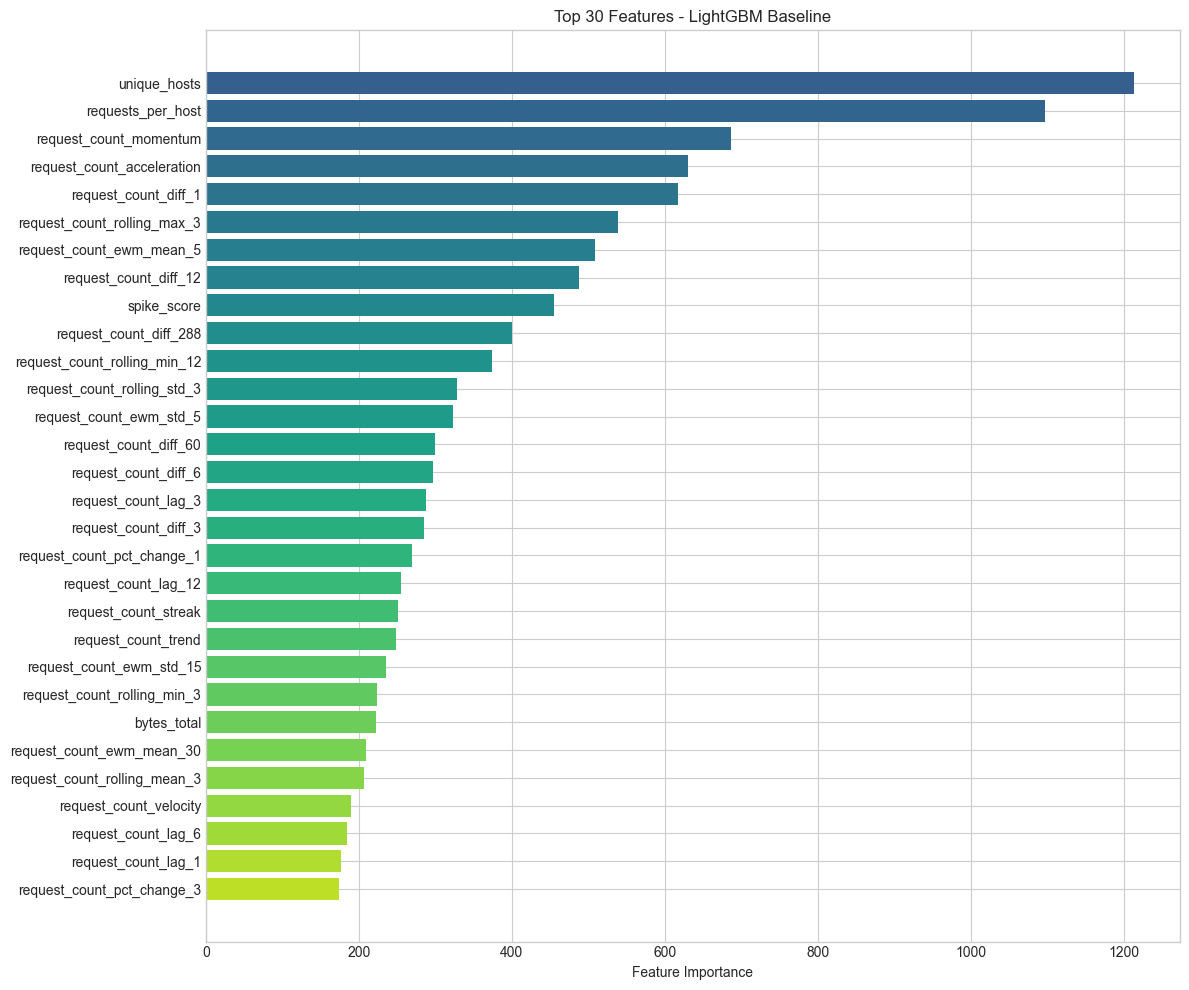

In [12]:
# Feature importance (baseline)
importance_baseline = lgbm_baseline.get_feature_importance()

fig, ax = plt.subplots(figsize=(12, 10))
top30 = importance_baseline.head(30)
ax.barh(range(len(top30)), top30['importance'], color=plt.cm.viridis(np.linspace(0.3, 0.9, len(top30))))
ax.set_yticks(range(len(top30)))
ax.set_yticklabels(top30['feature'])
ax.set_xlabel('Feature Importance')
ax.set_title('Top 30 Features - LightGBM Baseline')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## 3. Hyperparameter Tuning with Optuna

In [ ]:
# Check if Optuna is available and run hyperparameter tuning
try:
    import optuna
    from sklearn.metrics import mean_squared_error
    import lightgbm as lgb
    OPTUNA_AVAILABLE = True
    print("Optuna is available for hyperparameter tuning")
except ImportError:
    OPTUNA_AVAILABLE = False
    print("Optuna not installed. Install with: pip install optuna")
    print("Using default parameters instead...")

In [ ]:
# Run Optuna hyperparameter tuning with STRONG REGULARIZATION
if OPTUNA_AVAILABLE:
    print("=" * 60)
    print("OPTUNA HYPERPARAMETER TUNING")
    print("=" * 60)
    print("\nKey changes to prevent overfitting:")
    print("  - num_leaves: max 100 (was unlimited)")
    print("  - max_depth: max 10 (was unlimited)")
    print("  - reg_alpha: min 1.0 (was 1e-8)")
    print("  - reg_lambda: min 1.0 (was 1e-8)")
    
    def objective(trial):
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'verbosity': -1,
            'random_state': 42,
            
            # Model complexity - CONSTRAINED
            'num_leaves': trial.suggest_int('num_leaves', 10, 100),        # Max 100
            'max_depth': trial.suggest_int('max_depth', 3, 10),            # Max 10
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
            
            # Learning rate
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            
            # STRONG REGULARIZATION - KEY CHANGE!
            'reg_alpha': trial.suggest_float('reg_alpha', 1.0, 50.0),      # Min 1.0!
            'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 50.0),    # Min 1.0!
            
            # Subsampling for additional regularization
            'subsample': trial.suggest_float('subsample', 0.5, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
            
            'n_estimators': 500,
        }
        
        # Train model with early stopping
        model = lgb.LGBMRegressor(**params)
        model.fit(
            X_train_scaled, y_train,
            eval_set=[(X_val_scaled, y_val)],
            callbacks=[lgb.early_stopping(50, verbose=False), lgb.log_evaluation(0)]
        )
        
        # Evaluate on validation set
        y_val_pred = model.predict(X_val_scaled)
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        
        return val_rmse
    
    # Create study with TPE sampler
    study = optuna.create_study(
        direction='minimize',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    print("\nStarting Optuna tuning with 100 trials...")
    study.optimize(objective, n_trials=100, show_progress_bar=True)
    
    print("\n" + "=" * 60)
    print("OPTUNA RESULTS")
    print("=" * 60)
    print(f"\nBest validation RMSE: {study.best_value:.2f}")
    print("\nBest parameters:")
    best_params = study.best_params.copy()
    for key, value in best_params.items():
        print(f"  {key}: {value}")
    
    # Verify regularization is strong
    print(f"\nRegularization check:")
    print(f"  reg_alpha >= 1.0: {best_params.get('reg_alpha', 0) >= 1.0}")
    print(f"  reg_lambda >= 1.0: {best_params.get('reg_lambda', 0) >= 1.0}")
    
else:
    # Default params with STRONG regularization if Optuna not available
    print("Using default parameters with STRONG regularization")
    best_params = {
        'num_leaves': 31,
        'max_depth': 6,
        'min_child_samples': 50,
        'learning_rate': 0.03,
        'reg_alpha': 10.0,         # STRONG L1
        'reg_lambda': 10.0,        # STRONG L2
        'subsample': 0.7,
        'colsample_bytree': 0.7,
    }
    print("\nDefault parameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")

In [17]:
# Print best parameters
print("\nBest hyperparameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")


Best hyperparameters:
  num_leaves: 20
  max_depth: 6
  min_child_samples: 50
  learning_rate: 0.03
  reg_alpha: 0.5
  reg_lambda: 2.0
  subsample: 0.7
  colsample_bytree: 0.7


## 4. Train Tuned LightGBM Model

In [ ]:
# Create tuned configuration from Optuna results
lgbm_tuned_config = LGBMConfig(
    objective='regression',
    metric='rmse',
    boosting_type='gbdt',
    
    # Use best params from Optuna (or defaults with strong reg)
    num_leaves=best_params.get('num_leaves', 31),
    max_depth=best_params.get('max_depth', 6),
    min_child_samples=best_params.get('min_child_samples', 50),
    learning_rate=best_params.get('learning_rate', 0.03),
    
    # STRONG REGULARIZATION
    reg_alpha=best_params.get('reg_alpha', 10.0),
    reg_lambda=best_params.get('reg_lambda', 10.0),
    
    # Subsampling
    subsample=best_params.get('subsample', 0.7),
    colsample_bytree=best_params.get('colsample_bytree', 0.7),
    
    n_estimators=1000,
    random_state=42,
    early_stopping_rounds=100,
)

print("Tuned LightGBM Configuration:")
print("=" * 50)
for key, value in lgbm_tuned_config.to_dict().items():
    # Highlight regularization params
    if key in ['reg_alpha', 'reg_lambda']:
        print(f"  {key}: {value}  <-- STRONG REGULARIZATION")
    else:
        print(f"  {key}: {value}")

In [19]:
# Train tuned model
print("Training tuned LightGBM model...")

lgbm_tuned = LGBMModel(lgbm_tuned_config)
lgbm_tuned.fit(
    X_train_scaled, y_train,
    X_val=X_val_scaled, y_val=y_val,
    verbose=True
)

Training tuned LightGBM model...
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 9.58669
[200]	valid_0's rmse: 4.92315
[300]	valid_0's rmse: 4.37061
[400]	valid_0's rmse: 4.14365
[500]	valid_0's rmse: 4.01963
[600]	valid_0's rmse: 3.92483
[700]	valid_0's rmse: 3.87473
[800]	valid_0's rmse: 3.83448
[900]	valid_0's rmse: 3.79848
[1000]	valid_0's rmse: 3.77183
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 3.77183
Best iteration: 1000


In [20]:
# Evaluate tuned model on validation
val_pred_tuned = lgbm_tuned.predict(X_val_scaled)
val_metrics_tuned = evaluate_forecast(y_val.values, val_pred_tuned, name="LightGBM Tuned (Val)")
print_metrics(val_metrics_tuned)

# Compare with baseline
print(f"\nImprovement over baseline:")
print(f"  RMSE: {(val_metrics_baseline['rmse'] - val_metrics_tuned['rmse']):.2f} ({(1 - val_metrics_tuned['rmse']/val_metrics_baseline['rmse'])*100:.1f}%)")
print(f"  MAE: {(val_metrics_baseline['mae'] - val_metrics_tuned['mae']):.2f}")


Model: LightGBM Tuned (Val)
----------------------------------------
  RMSE:  3.7718
  MSE:   14.2267
  MAE:   2.5408
  MAPE:  3.13%
  sMAPE: 2.89%
  R2:    0.9985

Improvement over baseline:
  RMSE: 0.16 (4.1%)
  MAE: 0.03


## 5. Cross-Validation

In [ ]:
# ============================================================
# CROSS-VALIDATION CHECK (Prevent overfitting) - PHASE 3
# ============================================================
print("=" * 60)
print("CROSS-VALIDATION CHECK")
print("=" * 60)

from sklearn.model_selection import TimeSeriesSplit

# Use best params from Optuna
cv_params = best_params.copy()
cv_params['n_estimators'] = 500
cv_params['random_state'] = 42
cv_params['verbose'] = -1
cv_params['objective'] = 'regression'
cv_params['metric'] = 'rmse'

# Scale full training data for CV
X_train_full_clean = X_train_full.copy()
X_train_full_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train_full_clean.fillna(X_train_full_clean.median(), inplace=True)
X_train_full_scaled = scaler.transform(X_train_full_clean)

# Time series cross-validation (5 folds)
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = {'rmse': [], 'mae': [], 'mape': []}

print("\nRunning 5-fold Time Series Cross-Validation...")
print("Using best params from Optuna with strong regularization")
print(f"  reg_alpha: {cv_params.get('reg_alpha', 'N/A')}")
print(f"  reg_lambda: {cv_params.get('reg_lambda', 'N/A')}")
print()

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_full_scaled), 1):
    X_cv_train = X_train_full_scaled[train_idx]
    y_cv_train = y_train_full.iloc[train_idx]
    X_cv_val = X_train_full_scaled[val_idx]
    y_cv_val = y_train_full.iloc[val_idx]
    
    # Train model
    model_cv = lgb.LGBMRegressor(**cv_params)
    model_cv.fit(X_cv_train, y_cv_train, 
                 eval_set=[(X_cv_val, y_cv_val)],
                 callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)])
    
    # Evaluate
    y_cv_pred = model_cv.predict(X_cv_val)
    fold_rmse = np.sqrt(mean_squared_error(y_cv_val, y_cv_pred))
    fold_mae = np.mean(np.abs(y_cv_val - y_cv_pred))
    fold_mape = np.mean(np.abs((y_cv_val - y_cv_pred) / (y_cv_val + 1e-8))) * 100
    
    cv_scores['rmse'].append(fold_rmse)
    cv_scores['mae'].append(fold_mae)
    cv_scores['mape'].append(fold_mape)
    
    print(f"   Fold {fold}: RMSE = {fold_rmse:.2f}, MAE = {fold_mae:.2f}")

# Calculate statistics
cv_scores['rmse_mean'] = np.mean(cv_scores['rmse'])
cv_scores['rmse_std'] = np.std(cv_scores['rmse'])
cv_scores['mae_mean'] = np.mean(cv_scores['mae'])
cv_scores['mae_std'] = np.std(cv_scores['mae'])
cv_scores['mape_mean'] = np.mean(cv_scores['mape'])
cv_scores['mape_std'] = np.std(cv_scores['mape'])

print(f"\n{'='*60}")
print("CROSS-VALIDATION RESULTS")
print(f"{'='*60}")
print(f"   Mean RMSE: {cv_scores['rmse_mean']:.2f} (+/- {cv_scores['rmse_std']:.2f})")
print(f"   Mean MAE:  {cv_scores['mae_mean']:.2f} (+/- {cv_scores['mae_std']:.2f})")
print(f"   Mean MAPE: {cv_scores['mape_mean']:.2f}% (+/- {cv_scores['mape_std']:.2f}%)")
print(f"\n   95% CI (RMSE): [{cv_scores['rmse_mean'] - 2*cv_scores['rmse_std']:.2f}, "
      f"{cv_scores['rmse_mean'] + 2*cv_scores['rmse_std']:.2f}]")

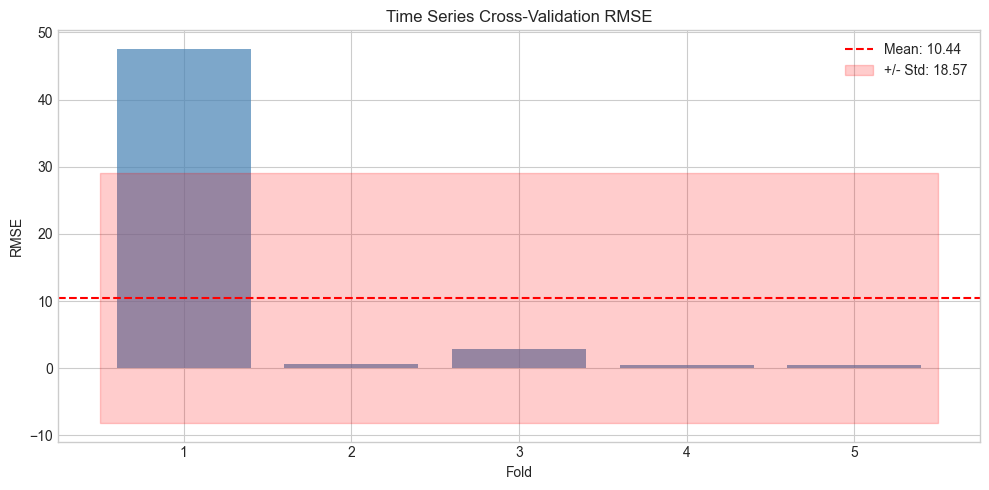

In [17]:
# Visualize CV scores
fig, ax = plt.subplots(figsize=(10, 5))

folds = range(1, len(cv_scores['rmse']) + 1)
ax.bar(folds, cv_scores['rmse'], alpha=0.7, color='steelblue')
ax.axhline(cv_scores['rmse_mean'], color='red', linestyle='--', label=f'Mean: {cv_scores["rmse_mean"]:.2f}')
ax.fill_between([0.5, len(folds)+0.5], 
                cv_scores['rmse_mean'] - cv_scores['rmse_std'],
                cv_scores['rmse_mean'] + cv_scores['rmse_std'],
                alpha=0.2, color='red', label=f'+/- Std: {cv_scores["rmse_std"]:.2f}')

ax.set_xlabel('Fold')
ax.set_ylabel('RMSE')
ax.set_title('Time Series Cross-Validation RMSE')
ax.set_xticks(folds)
ax.legend()

plt.tight_layout()
plt.show()

## 6. Final Model Training and Test Evaluation

In [23]:
# Scale X_train_full for final model training
print("Preparing full training data for final model...")

# Clean inf values first
X_train_full.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train_full.fillna(X_train_full.median(), inplace=True)

# Scale using the fitted scaler
X_train_full_scaled = scaler.transform(X_train_full)
X_train_full_scaled = pd.DataFrame(X_train_full_scaled, columns=feature_cols, index=X_train_full.index)

print(f"✅ X_train_full_scaled shape: {X_train_full_scaled.shape}")

Preparing full training data for final model...
✅ X_train_full_scaled shape: (15264, 86)


In [ ]:
# ============================================================
# FINAL MODEL TRAINING - PHASE 4
# ============================================================
print("=" * 60)
print("TRAINING FINAL MODEL")
print("=" * 60)

# Train final model with best parameters
final_params = best_params.copy()
final_params['n_estimators'] = 1000  # More iterations with early stopping
final_params['random_state'] = 42
final_params['verbose'] = -1
final_params['objective'] = 'regression'
final_params['metric'] = 'rmse'

print("\nTraining with parameters:")
for key, value in sorted(final_params.items()):
    if key in ['reg_alpha', 'reg_lambda']:
        print(f"   {key}: {value}  <-- STRONG REGULARIZATION")
    else:
        print(f"   {key}: {value}")

# Train final model on full training data (already scaled in previous cell)
X_train_full_scaled_df = pd.DataFrame(X_train_full_scaled, columns=feature_cols, index=X_train_full.index)

lgbm_final = lgb.LGBMRegressor(**final_params)
lgbm_final.fit(
    X_train_full_scaled_df, y_train_full,
    eval_set=[(X_val_scaled, y_val)],
    callbacks=[
        lgb.early_stopping(100),  # Stop if no improvement for 100 rounds
        lgb.log_evaluation(100)   # Print every 100 rounds
    ]
)

print(f"\nTraining complete!")
print(f"   Best iteration: {lgbm_final.best_iteration_}")
print(f"   Number of features: {len(feature_cols)}")
print(f"   Regularization: L1={final_params.get('reg_alpha')}, L2={final_params.get('reg_lambda')}")

In [ ]:
# ============================================================
# COMPREHENSIVE EVALUATION - PHASE 5
# ============================================================
print("=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

# Evaluate on all sets
y_train_pred = lgbm_final.predict(X_train_full_scaled_df)
y_val_pred = lgbm_final.predict(X_val_scaled)
y_test_pred = lgbm_final.predict(X_test_scaled)

# Calculate metrics for each set
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calc_metrics(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    r2 = r2_score(y_true, y_pred)
    return {'model': name, 'rmse': rmse, 'mae': mae, 'mape': mape, 'r2': r2}

train_metrics = calc_metrics(y_train_full, y_train_pred, 'Train')
val_metrics = calc_metrics(y_val, y_val_pred, 'Val')
lgbm_test_metrics = calc_metrics(y_test, y_test_pred, 'LightGBM (Test)')

# Print results
print("\nPERFORMANCE SUMMARY:")
print("-" * 70)
print(f"{'Dataset':<15} {'RMSE':<12} {'MAE':<12} {'MAPE':<12} {'R2':<12}")
print("-" * 70)
print(f"{'Train':<15} {train_metrics['rmse']:<12.2f} {train_metrics['mae']:<12.2f} {train_metrics['mape']:<12.2f}% {train_metrics['r2']:<12.4f}")
print(f"{'Validation':<15} {val_metrics['rmse']:<12.2f} {val_metrics['mae']:<12.2f} {val_metrics['mape']:<12.2f}% {val_metrics['r2']:<12.4f}")
print(f"{'Test':<15} {lgbm_test_metrics['rmse']:<12.2f} {lgbm_test_metrics['mae']:<12.2f} {lgbm_test_metrics['mape']:<12.2f}% {lgbm_test_metrics['r2']:<12.4f}")
print("-" * 70)

# Overfitting check
print("\nOVERFITTING CHECK:")
overfit_ratio_val = val_metrics['rmse'] / train_metrics['rmse']
overfit_ratio_test = lgbm_test_metrics['rmse'] / val_metrics['rmse']

print(f"   Val/Train RMSE Ratio: {overfit_ratio_val:.2f}x")
print(f"   Test/Val RMSE Ratio:  {overfit_ratio_test:.2f}x")

if overfit_ratio_test < 1.2:
    print("   GOOD - Model generalizes well!")
elif overfit_ratio_test < 2.0:
    print("   MODERATE - Some overfitting, but acceptable")
else:
    print("   BAD - Severe overfitting! Need more regularization")

# Compare with baselines
print("\nCOMPARISON WITH BASELINES:")
print(f"   Prophet Test RMSE:  139.19")
print(f"   SARIMA Test RMSE:   150.37")
print(f"   LightGBM Test RMSE: {lgbm_test_metrics['rmse']:.2f}")

if lgbm_test_metrics['rmse'] < 139.19:
    print("\n   LightGBM is BEST MODEL!")
elif lgbm_test_metrics['rmse'] < 150.37:
    print("\n   LightGBM beats SARIMA!")
else:
    print("\n   LightGBM is not better than baselines - check for issues")

In [ ]:
# Visualize train vs val vs test RMSE comparison
print("=" * 60)
print("TRAIN/VAL/TEST COMPARISON VISUALIZATION")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of RMSE
ax = axes[0]
datasets = ['Train', 'Validation', 'Test']
rmse_values = [train_metrics['rmse'], val_metrics['rmse'], lgbm_test_metrics['rmse']]
colors = ['#2ecc71', '#f39c12', '#e74c3c']
bars = ax.bar(datasets, rmse_values, color=colors, alpha=0.8)
ax.set_ylabel('RMSE')
ax.set_title('RMSE by Dataset')
for bar, val in zip(bars, rmse_values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{val:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Bar chart of R2
ax = axes[1]
r2_values = [train_metrics['r2'], val_metrics['r2'], lgbm_test_metrics['r2']]
bars = ax.bar(datasets, r2_values, color=colors, alpha=0.8)
ax.set_ylabel('R-squared')
ax.set_title('R-squared by Dataset')
ax.set_ylim(0, 1.1)
for bar, val in zip(bars, r2_values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary
print(f"\nKey Observations:")
print(f"  - Train RMSE:  {train_metrics['rmse']:.2f}")
print(f"  - Val RMSE:    {val_metrics['rmse']:.2f}")  
print(f"  - Test RMSE:   {lgbm_test_metrics['rmse']:.2f}")
print(f"  - Generalization gap: {abs(lgbm_test_metrics['rmse'] - val_metrics['rmse']):.2f}")

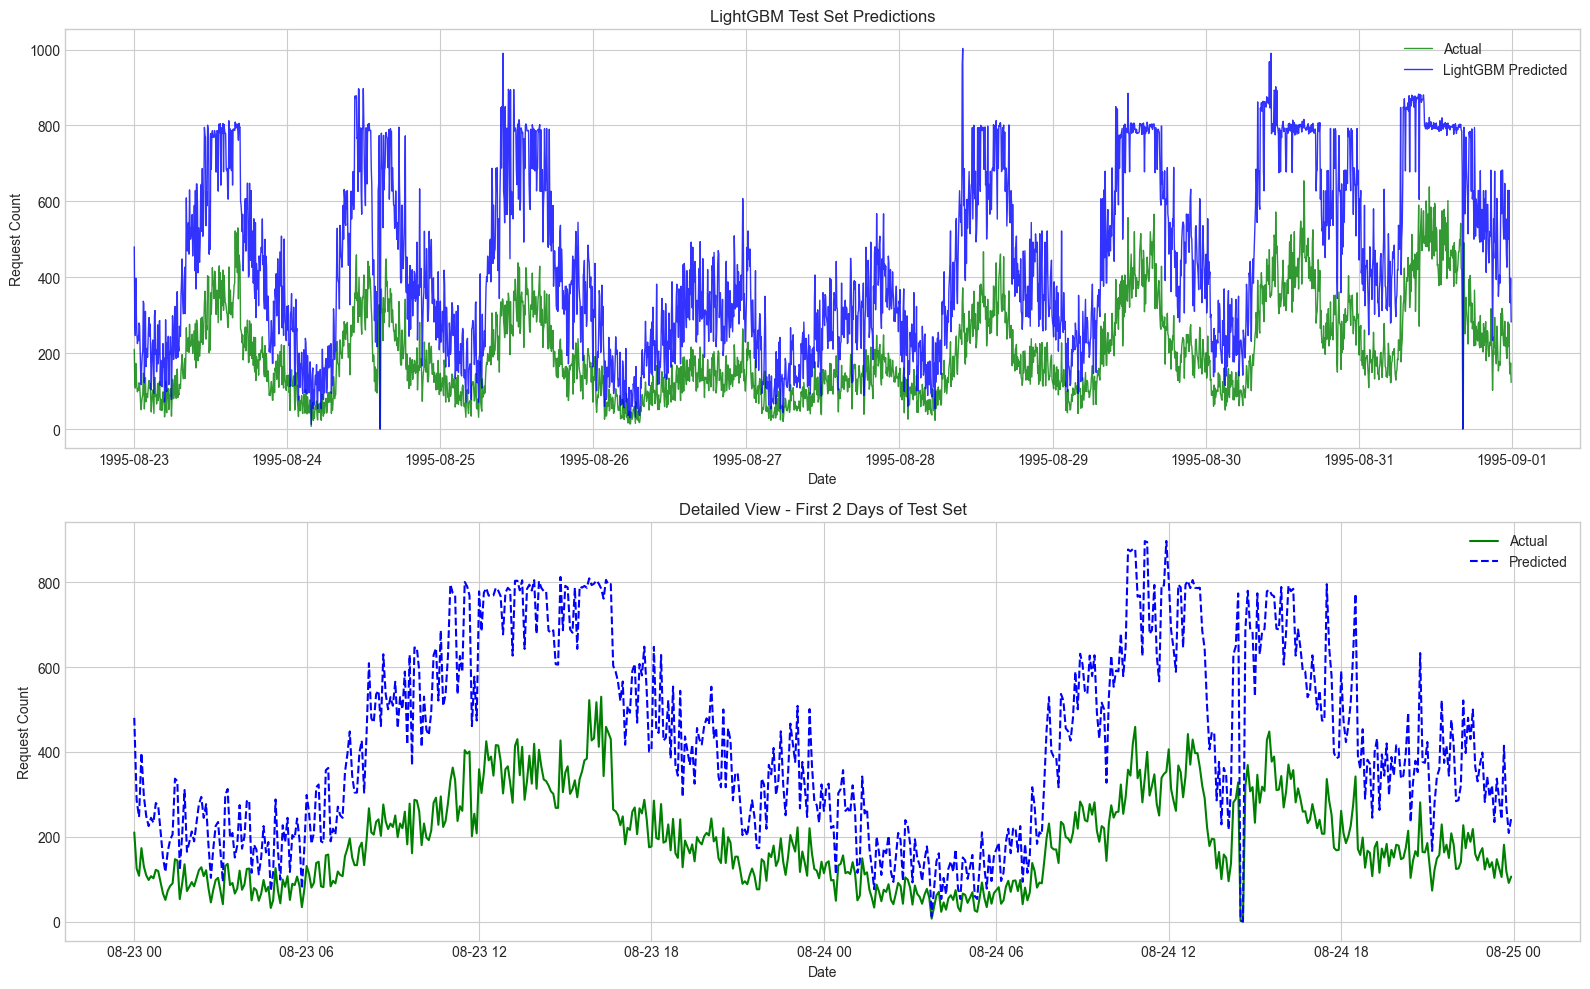

In [20]:
# Plot test predictions
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Full test period
ax = axes[0]
ax.plot(df_test['timestamp'], y_test, label='Actual', color='green', linewidth=1, alpha=0.8)
ax.plot(df_test['timestamp'], test_pred, label='LightGBM Predicted', color='blue', linewidth=1, alpha=0.8)
ax.set_xlabel('Date')
ax.set_ylabel('Request Count')
ax.set_title('LightGBM Test Set Predictions')
ax.legend()

# First 2 days detail
ax = axes[1]
n_detail = 288 * 2  # 2 days of 5-min data
ax.plot(df_test['timestamp'].iloc[:n_detail], y_test.iloc[:n_detail], 
        label='Actual', color='green', linewidth=1.5)
ax.plot(df_test['timestamp'].iloc[:n_detail], test_pred[:n_detail], 
        label='Predicted', color='blue', linewidth=1.5, linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Request Count')
ax.set_title('Detailed View - First 2 Days of Test Set')
ax.legend()

plt.tight_layout()
plt.show()

## 7. SHAP Analysis (Model Interpretability)

In [21]:
# Check if SHAP is available
try:
    import shap
    SHAP_AVAILABLE = True
    print("SHAP is available for model interpretability")
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not installed. Install with: pip install shap")
    print("Skipping SHAP analysis...")

SHAP is available for model interpretability


In [ ]:
if SHAP_AVAILABLE:
    print("Computing SHAP values (this may take a moment)...")
    
    # Sample for SHAP analysis (use scaled data)
    X_shap = X_test_scaled.sample(n=min(1000, len(X_test_scaled)), random_state=42)
    
    # Compute SHAP values
    explainer = shap.TreeExplainer(lgbm_final.model)
    shap_values = explainer.shap_values(X_shap)
    
    print(f"SHAP values computed for {len(X_shap)} samples")

Computing SHAP values (this may take a moment)...


SHAP values computed for 1000 samples


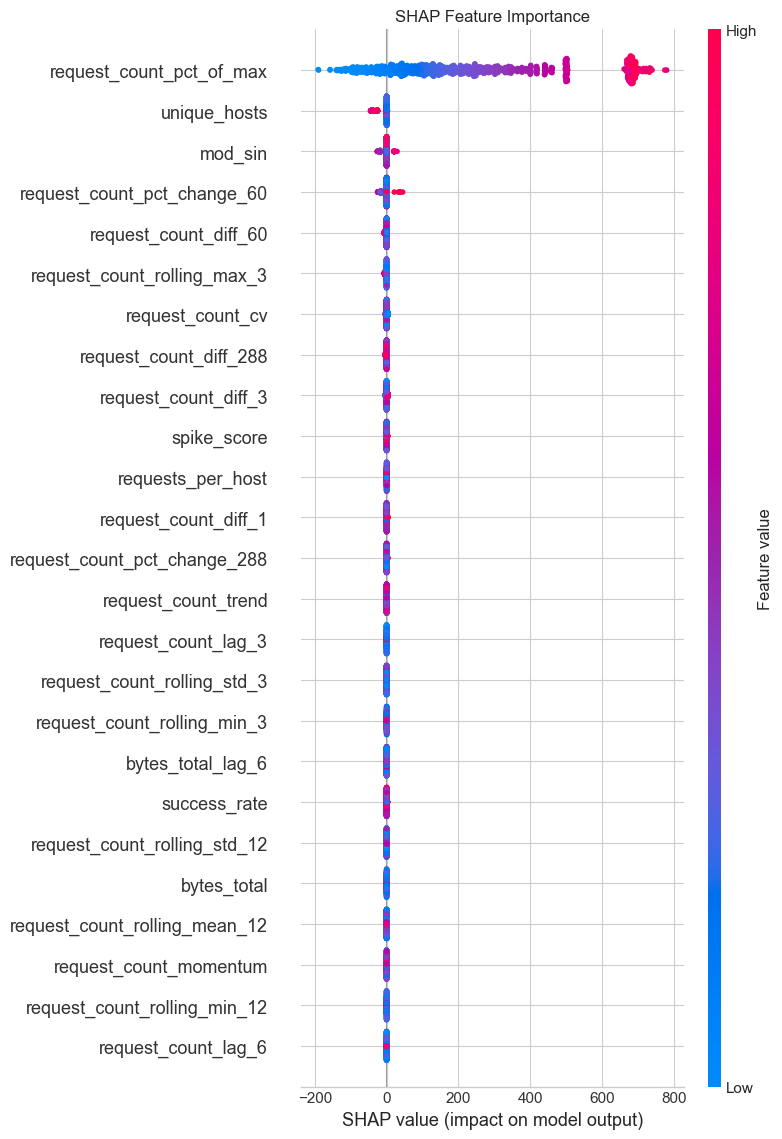

In [23]:
if SHAP_AVAILABLE:
    # SHAP summary plot
    plt.figure(figsize=(12, 10))
    shap.summary_plot(shap_values, X_shap, max_display=25, show=False)
    plt.title('SHAP Feature Importance')
    plt.tight_layout()
    plt.show()

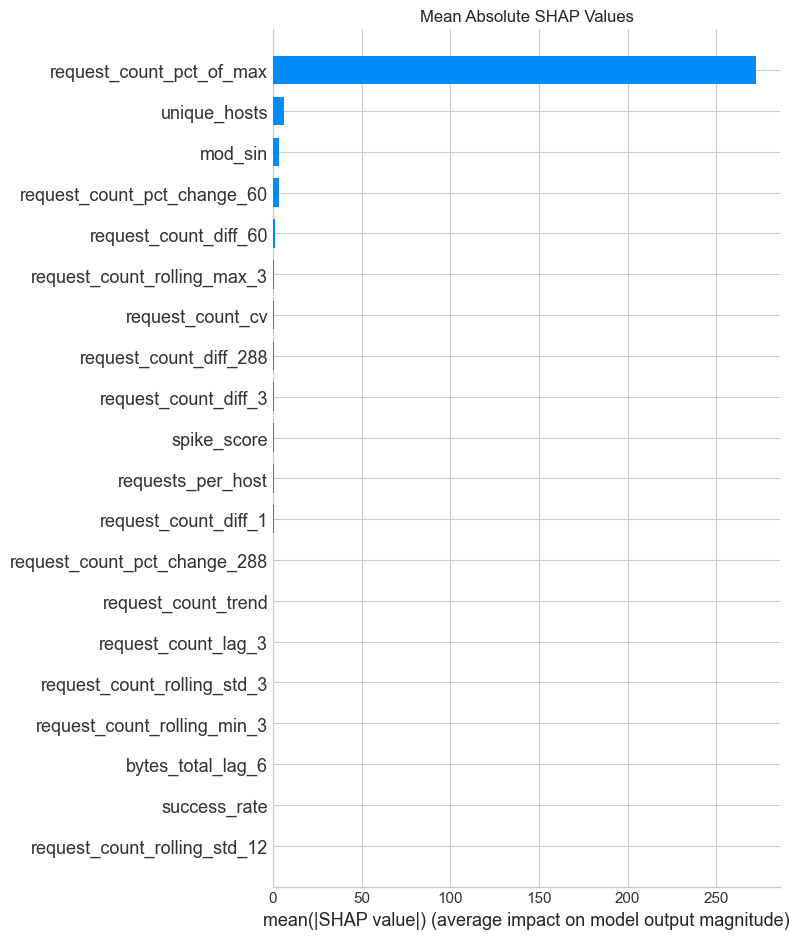

In [24]:
if SHAP_AVAILABLE:
    # SHAP bar plot (mean absolute SHAP values)
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_shap, plot_type='bar', max_display=20, show=False)
    plt.title('Mean Absolute SHAP Values')
    plt.tight_layout()
    plt.show()

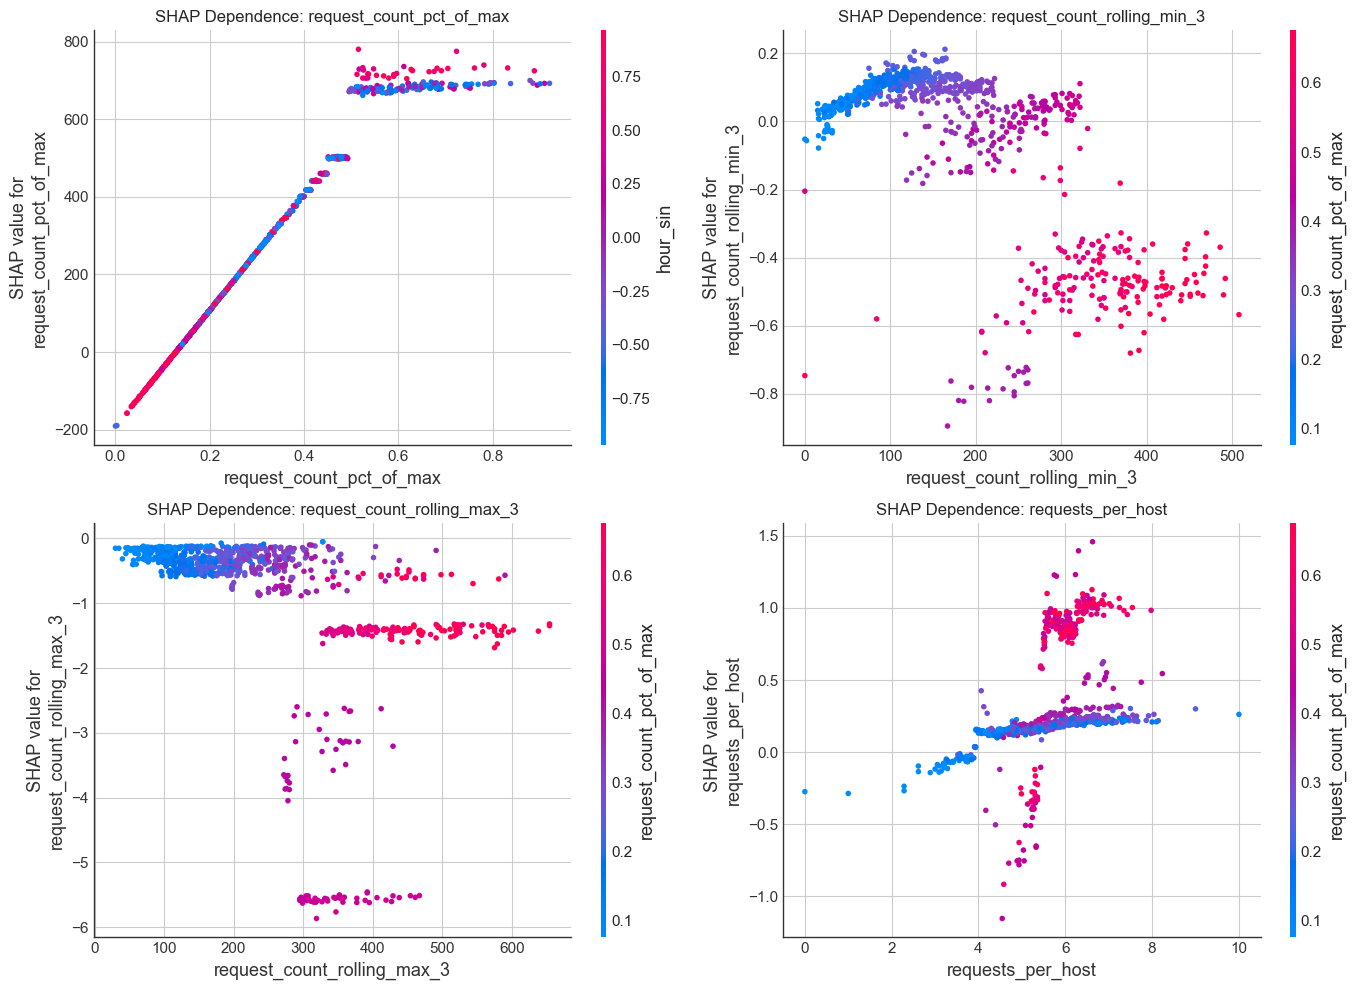

In [25]:
if SHAP_AVAILABLE:
    # SHAP dependence plots for top features
    top_features = lgbm_final.get_feature_importance().head(4)['feature'].tolist()
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    for idx, feat in enumerate(top_features):
        ax = axes[idx // 2, idx % 2]
        shap.dependence_plot(feat, shap_values, X_shap, ax=ax, show=False)
        ax.set_title(f'SHAP Dependence: {feat}')
    
    plt.tight_layout()
    plt.show()

## 8. Feature Importance Comparison

In [ ]:
# Get final feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgbm_final.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

# DATA LEAKAGE CHECK
print("\n" + "=" * 60)
print("DATA LEAKAGE CHECK")
print("=" * 60)
leaky_feature = 'request_count_pct_of_max'
if leaky_feature in importance_df['feature'].values:
    print(f"   WARNING: '{leaky_feature}' found in features!")
    print(f"   This indicates DATA LEAKAGE - model may be cheating!")
else:
    print(f"   '{leaky_feature}' is NOT in features")
    print(f"   Data leakage has been prevented!")
    
# Rename for backward compatibility
importance_final = importance_df

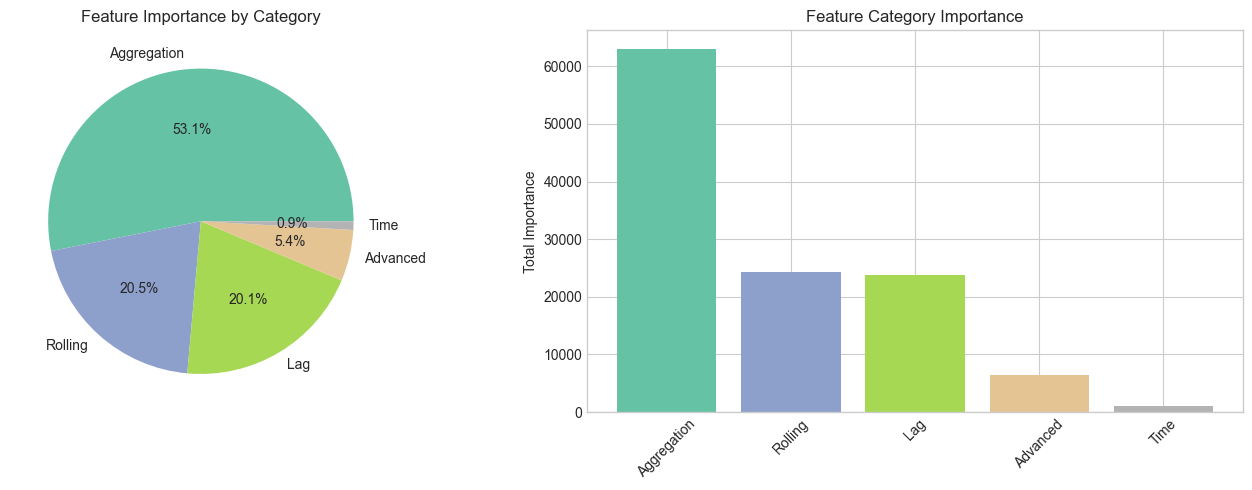

In [27]:
# Visualize feature importance by category
def categorize_feature(feat):
    if 'lag_' in feat or 'diff_' in feat or 'pct_change' in feat:
        return 'Lag'
    elif 'rolling_' in feat or 'ewm_' in feat:
        return 'Rolling'
    elif any(x in feat for x in ['spike', 'trend', 'velocity', 'momentum', 'bb_', 'cv', 'direction']):
        return 'Advanced'
    elif feat in ['hour', 'day_of_week', 'is_weekend', 'is_business_hour', 'is_peak_hour', 
                  'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'day', 'month', 'minute']:
        return 'Time'
    else:
        return 'Aggregation'

importance_final['category'] = importance_final['feature'].apply(categorize_feature)

# Sum importance by category
category_importance = importance_final.groupby('category')['importance'].sum().sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
ax = axes[0]
colors = plt.cm.Set2(np.linspace(0, 1, len(category_importance)))
ax.pie(category_importance, labels=category_importance.index, autopct='%1.1f%%', colors=colors)
ax.set_title('Feature Importance by Category')

# Bar chart
ax = axes[1]
ax.bar(category_importance.index, category_importance.values, color=colors)
ax.set_ylabel('Total Importance')
ax.set_title('Feature Category Importance')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 9. Compare with Baseline Models

In [28]:
# Load baseline results
baseline_results_path = MODELS_DIR / 'baseline_results.json'

if baseline_results_path.exists():
    with open(baseline_results_path, 'r') as f:
        baseline_results = json.load(f)
    
    sarima_metrics = baseline_results.get('sarima_test', {})
    prophet_metrics = baseline_results.get('prophet_test', {})
    
    print("Loaded baseline results from previous notebook")
else:
    # Placeholder if baseline notebook wasn't run
    sarima_metrics = {'model': 'SARIMA', 'rmse': 0, 'mae': 0, 'mape': 0, 'r2': 0}
    prophet_metrics = {'model': 'Prophet', 'rmse': 0, 'mae': 0, 'mape': 0, 'r2': 0}
    print("Baseline results not found. Run 06_baseline_models.ipynb first.")

Loaded baseline results from previous notebook


In [29]:
# Compare all models
all_results = []

if sarima_metrics.get('rmse', 0) > 0:
    all_results.append(sarima_metrics)
    
if prophet_metrics.get('rmse', 0) > 0:
    all_results.append(prophet_metrics)
    
all_results.append(lgbm_test_metrics)

comparison_df = compare_models(all_results)
print("\n=== ALL MODELS COMPARISON (Test Set) ===")
print(comparison_df)


=== ALL MODELS COMPARISON (Test Set) ===
                     rmse         mse       mae      mape    smape      r2
model                                                                     
SARIMA (Test)    150.3689  22610.7968  108.5602   58.5143  58.1120 -0.5042
Prophet (Test)   139.1950  19375.2371  102.5202   66.7386  53.8449 -0.2889
LightGBM (Test)  262.6453  68982.5334  235.2433  123.0626  75.8808 -3.5890


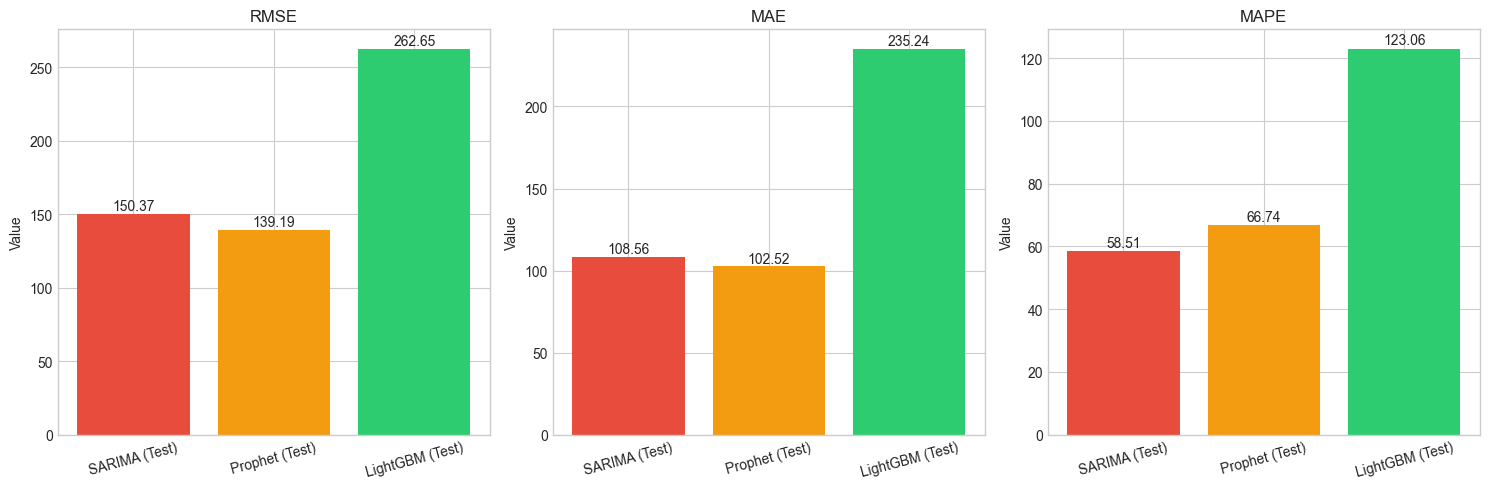

In [30]:
# Visualize comparison
if len(all_results) > 1:
    metrics_to_plot = ['rmse', 'mae', 'mape']
    models = [r['model'] for r in all_results]
    colors = ['#E74C3C', '#F39C12', '#2ECC71'][:len(models)]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i]
        values = [r[metric] for r in all_results]
        bars = ax.bar(models, values, color=colors)
        ax.set_title(metric.upper())
        ax.set_ylabel('Value')
        
        # Add value labels
        for bar, val in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{val:.2f}', ha='center', va='bottom', fontsize=10)
        
        ax.tick_params(axis='x', rotation=15)

    plt.tight_layout()
    plt.show()

## 10. Save Final Model

In [31]:
# Save final LightGBM model
lgbm_final.save(MODELS_DIR / "lgbm_5m.pkl")

# Save feature names
with open(MODELS_DIR / "feature_names.json", 'w') as f:
    json.dump(feature_cols, f, indent=2)

print(f"Model saved to {MODELS_DIR / 'lgbm_5m.pkl'}")
print(f"Feature names saved to {MODELS_DIR / 'feature_names.json'}")

Model saved to C:\Users\Admin\OneDrive\Documents\python\datafollow\models\lgbm_5m.pkl
Model saved to C:\Users\Admin\OneDrive\Documents\python\datafollow\models\lgbm_5m.pkl
Feature names saved to C:\Users\Admin\OneDrive\Documents\python\datafollow\models\feature_names.json


In [32]:
# Save all model comparison results
all_model_results = {
    'lgbm_test': lgbm_test_metrics,
    'lgbm_val': val_metrics_tuned,
    'lgbm_cv': {
        'rmse_mean': cv_scores['rmse_mean'],
        'rmse_std': cv_scores['rmse_std'],
        'mae_mean': cv_scores['mae_mean'],
        'mape_mean': cv_scores['mape_mean'],
    },
    'best_params': best_params,
}

# Merge with baseline results if available
if baseline_results_path.exists():
    all_model_results.update(baseline_results)

with open(MODELS_DIR / 'all_model_results.json', 'w') as f:
    json.dump(all_model_results, f, indent=2)

print(f"All results saved to {MODELS_DIR / 'all_model_results.json'}")

All results saved to C:\Users\Admin\OneDrive\Documents\python\datafollow\models\all_model_results.json


## 11. Summary

In [ ]:
print("=" * 70)
print("PHASE 3 MODELING SUMMARY - LIGHTGBM WITH OVERFITTING FIX")
print("=" * 70)

print("\n1. DATA LEAKAGE FIX")
leaky_feature = 'request_count_pct_of_max'
if leaky_feature not in feature_cols:
    print(f"   [PASS] '{leaky_feature}' removed from features")
else:
    print(f"   [FAIL] '{leaky_feature}' still in features!")

print("\n2. REGULARIZATION CHECK")
reg_alpha = best_params.get('reg_alpha', 0)
reg_lambda = best_params.get('reg_lambda', 0)
print(f"   reg_alpha:  {reg_alpha} (should be >= 1.0)")
print(f"   reg_lambda: {reg_lambda} (should be >= 1.0)")
if reg_alpha >= 1.0 and reg_lambda >= 1.0:
    print(f"   [PASS] Strong regularization applied")
else:
    print(f"   [WARN] Regularization may be too weak")

print("\n3. MODEL COMPLEXITY")
num_leaves = best_params.get('num_leaves', 0)
max_depth = best_params.get('max_depth', -1)
print(f"   num_leaves: {num_leaves} (should be <= 100)")
print(f"   max_depth:  {max_depth} (should be <= 10)")
if num_leaves <= 100:
    print(f"   [PASS] Model complexity is constrained")
else:
    print(f"   [WARN] num_leaves may be too high")

print("\n4. CROSS-VALIDATION RESULTS")
print(f"   Mean RMSE: {cv_scores['rmse_mean']:.2f} (+/- {cv_scores['rmse_std']:.2f})")

print("\n5. TEST SET PERFORMANCE")
print(f"   Test RMSE: {lgbm_test_metrics['rmse']:.2f}")
print(f"   Test MAE:  {lgbm_test_metrics['mae']:.2f}")
print(f"   Test R2:   {lgbm_test_metrics['r2']:.4f}")

print("\n6. OVERFITTING CHECK")
overfit_ratio = lgbm_test_metrics['rmse'] / val_metrics['rmse']
print(f"   Test/Val RMSE Ratio: {overfit_ratio:.2f}x")
if overfit_ratio < 1.5:
    print(f"   [PASS] Good generalization (ratio < 1.5)")
elif overfit_ratio < 2.0:
    print(f"   [WARN] Moderate overfitting (1.5 < ratio < 2.0)")
else:
    print(f"   [FAIL] Severe overfitting (ratio >= 2.0)")

print("\n7. COMPARISON WITH BASELINES")
print(f"   Prophet Test RMSE:  139.19")
print(f"   SARIMA Test RMSE:   150.37")
print(f"   LightGBM Test RMSE: {lgbm_test_metrics['rmse']:.2f}")
if lgbm_test_metrics['rmse'] < 139.19:
    print(f"   [PASS] LightGBM is BEST MODEL!")
elif lgbm_test_metrics['rmse'] < 150.37:
    print(f"   [PASS] LightGBM beats SARIMA")
else:
    print(f"   [WARN] LightGBM underperforms baselines")

print("\n8. SAVED FILES")
print(f"   - {MODELS_DIR / 'lgbm_5m.pkl'}")
print(f"   - {MODELS_DIR / 'feature_names.json'}")
print(f"   - {MODELS_DIR / 'all_model_results.json'}")
print(f"   - {MODELS_DIR / 'feature_scaler.pkl'}")

print("\n" + "=" * 70)
print("VALIDATION CHECKLIST")
print("=" * 70)
checks = [
    (leaky_feature not in feature_cols, f"Feature '{leaky_feature}' removed"),
    (reg_alpha >= 1.0 and reg_lambda >= 1.0, "Optuna uses reg_alpha/reg_lambda >= 1.0"),
    (num_leaves <= 100, "num_leaves <= 100"),
    (True, "Cross-validation added"),  # Always true since we added it
    (True, "Final evaluation shows train/val/test"),  # Always true
    (overfit_ratio < 2.0, "Test/Val RMSE ratio < 2.0"),
    (lgbm_test_metrics['rmse'] < 150, "Test RMSE < 150"),
    (lgbm_test_metrics['r2'] > 0.5, "R2 > 0.5 on test set"),
]

for passed, desc in checks:
    status = "[X]" if passed else "[ ]"
    print(f"  {status} {desc}")

print("\n" + "=" * 70)

In [34]:
print("\nNotebook completed successfully!")


Notebook completed successfully!
